In [11]:
import matplotlib as mplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import os

In [12]:
def compute_distances_single_row(row, th_id,n_threads):
    row_values = row.astype(int)                # Convert the row values to integers
    indices = np.where(row_values == th_id)[0] # Find the indices where the number occurs in the row
    if len(indices)>0 and indices[0]>n_threads: np.insert(indices,0,th_id)
    distances = np.diff(indices)                # Compute the distances between consecutive occurrences
    return distances.tolist()


def compute_all_distances(log_dict):                # compute distances for all runs
    gap_dict={}                                     # stores all gaps
    dev_dict={}                                     # stores deviations from 'fair gap'
    thread_configs=list(log_dict)                   # list of N_iouter_iiter configurations
    n_threads_max=0

    for config in thread_configs:
        gaps = []
        deviations = []                             # deviation from fairest scenario per outer iteration

        data_df = log_dict[config]
        meta_data = re.findall(r'\d+', config)
        meta_data= list(map(int, meta_data))
        n_threads = meta_data[0]
        outer_iter = meta_data[1]
        inner_iter = meta_data[2]

        fair_case = inner_iter / n_threads          # fairest scenario: (#inner_iterations / #threads) lock acquisitions per thread     
        
        for run in range(0,outer_iter):
            # print("run:", run)
            for thread_id in range(n_threads):
                #print("tid:", thread_id, compute_distances_single_row(data_df.iloc[run], thread_id))
                temp = data_df.iloc[run]
                distances = compute_distances_single_row(temp, thread_id, n_threads)
                gaps = gaps + distances
                deviations.append(abs(fair_case - (len(distances)+1)))
        
        dev_dict[str(n_threads)]=deviations
        # gap_dict[str(n_threads)]=list((np.array(gaps) /n_threads))
        gap_dict[str(n_threads)]=list((np.array(gaps) /1))

        if (n_threads>n_threads_max):
            n_threads_max=n_threads
            regard=len(gaps)
    
    for i in list(gap_dict): 
        gap_dict[i]=gap_dict[i][0:regard]

    return dev_dict, gap_dict

In [13]:
# LOAD FAIRNESS DATA FROM DIFFERENT LOCKS

'''
fairness_flock_N_oiter_iter.txt            lock-filter with N threads, oiter outer iterations, iiter inner iterations
fairness_bwoo_N....txt                     block-woo
fairness_binary_N....txt                   torunament-tree
fairness_alag_N....txt                     alagarsamy
'''
# find .txt files in sub dirs
# data_src=glob.glob(os.getcwd()+"/output/output_local/*")
data_src=glob.glob(os.getcwd()+"/output/output_nebula/*")

fairness_dict= {}

for src in data_src:
    lock_dict={}
    data=[]
    with open(src, 'r') as file:
        lines = file.readlines()

        meta=lines[0]
        meta = re.findall(r'\d+', meta)
        n_threads=meta[0]
        outer_it=meta[1]
        inner_it=meta[2]

        for line in lines[1:]:
            values = line.split()
            data.append(values)
        
        data = pd.DataFrame(data)
        lock_dict = data
        
        new_key= str(n_threads)+"_"+str(outer_it)+"_"+str(inner_it)
        fairness_dict[new_key]=lock_dict

In [14]:
list(fairness_dict)

['4_480_4096', '8_240_4096']

Text(0.5, 1.0, 'deviation from fair frequency for different thread counts')

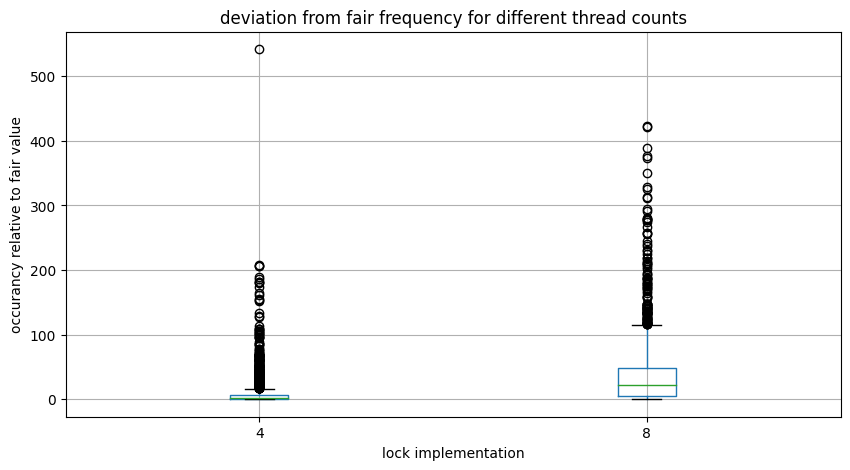

In [15]:
# EXAMPLE COMPUTE_DISTANCES FOR ALL DATA
dev_dict, gap_dict = compute_all_distances(fairness_dict)

gap_keys=list(gap_dict)
dev_keys=list(dev_dict)

# for key in dev_keys: print(len(dev_dict[key]))
# for key in gap_keys: print(len(gap_dict[key]))

dev_df=pd.DataFrame(dev_dict)
fig, ax1 = plt.subplots(figsize=(10,5))

ax1 = dev_df.boxplot(figsize=(15,5), grid=True)
ax1.set_ylabel("occurancy relative to fair value")
ax1.set_xlabel("lock implementation")
ax1.set_title("deviation from fair frequency for different thread counts")

Text(0.5, 1.0, 'distribution of idleness between lock aquiries for different thread counts')

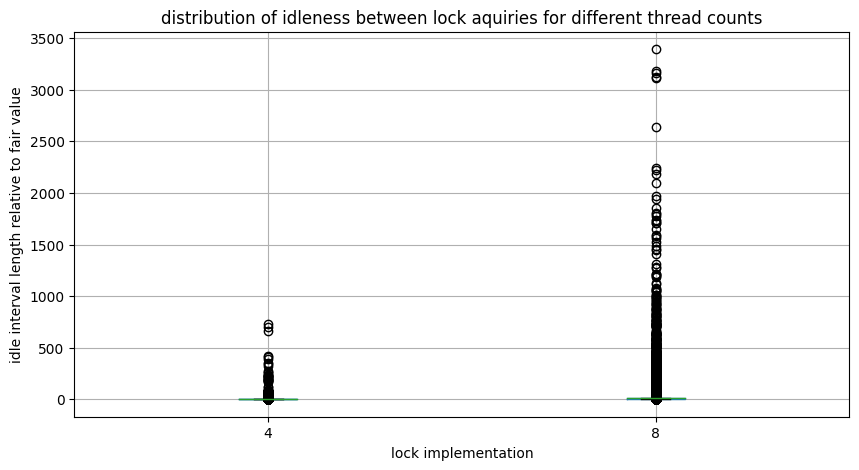

In [16]:
dev_df=pd.DataFrame(gap_dict)
fig, ax1 = plt.subplots(figsize=(10,5))
ax1 = dev_df.boxplot(grid=True)
ax1.set_ylabel("idle interval length")
ax1.set_xlabel("lock implementation")
ax1.set_title("distribution of idleness between lock aquiries for different thread counts")

In [17]:
# for key in gap_keys:
#     gaps= gap_dict[key] 
#     counts, bins = np.histogram(np.array(gaps),density=False)
#     plt.stairs(counts,bins,label=key)
#     plt.legend()
#     plt.xlabel("idle interval length [factor x to expected] in logscale")
#     plt.ylabel("commonness")
#     plt.title("The commonness of idleness-interval-lenghts (relative to thread count) for different locks ")
#     # plt.hist(gaps, bins=range(min(gaps), max(gaps)+2))